In [1]:
import json
import os
import re
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from IPython import get_ipython
from IPython.core.display import HTML
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import stata_setup
stata_setup.config('/home/jovyan/kay/stata_bin', 'mp', splash=False)
from pystata import stata

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 20)
pd.set_option('display.max_rows', 120)
pd.set_option('display.expand_frame_repr', False)

df = pd.read_parquet("oecd.gzip")

In [12]:
# Select only direct migrants

df = df[df["migback"].isin([2])]

In [13]:
# Centering peer satisfaction
mean_satisf_peers = df['satisf_peers'].mean()

df['satisf_peers'] = df['satisf_peers'] - mean_satisf_peers

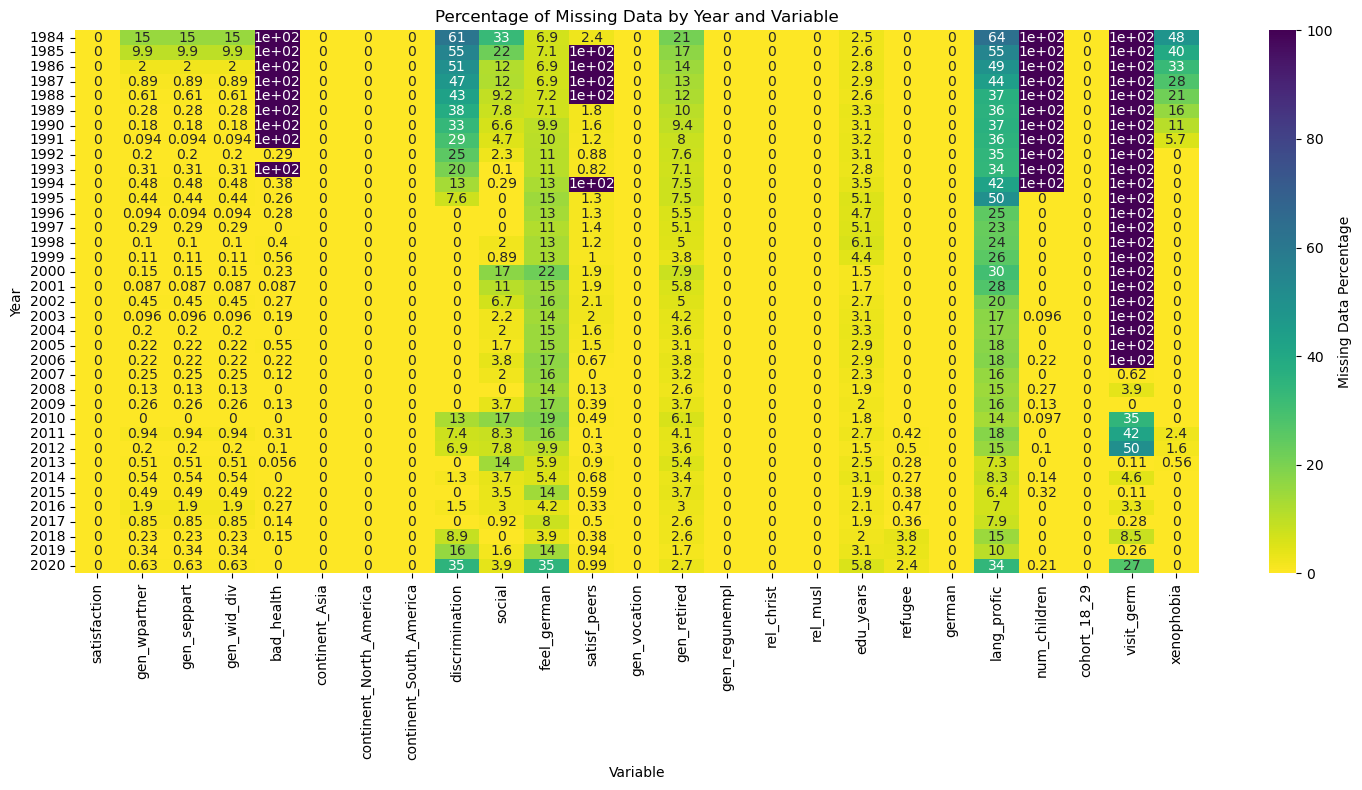

In [14]:
# Plot the percentage of missing data for various variables

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.nonparametric.smoothers_lowess import lowess

# Plot missing values caused by inclusion of variables

variables = ['satisfaction', 'gen_wpartner', 'gen_seppart', 'gen_wid_div', 'bad_health', 
             'continent_Asia', 'continent_North_America', 'continent_South_America', 'discrimination', 
             'social', 'feel_german', 'satisf_peers', 'gen_vocation', 'gen_retired', 'gen_regunempl',
             'rel_christ', 'rel_musl', 'edu_years', 'refugee', 'german', 'lang_profic', 
             'num_children', 'cohort_18_29', "syear", "visit_germ", "xenophobia"]

data = df[variables]


missing_data_by_year = data.groupby('syear').apply(lambda x: x.drop(columns='syear').dropna().shape[0] / x.shape[0] * 100)

missing_data_df = missing_data_by_year.reset_index()
missing_data_df.columns = ['syear', 'Available Data Percentage']

missing_data_percent = data.groupby('syear').apply(lambda x: x.isnull().mean() * 100).drop(columns='syear')

plt.figure(figsize=(15, 8))
sns.heatmap(missing_data_percent, cmap='viridis_r', annot=True, cbar_kws={'label': 'Missing Data Percentage'})

plt.title('Percentage of Missing Data by Year and Variable')
plt.xlabel('Variable')
plt.ylabel('Year')
plt.tight_layout()
plt.show();

In [15]:
%%stata -d df -force
* Forward selection
stepwise reg satisfaction (gen_wpartner gen_seppart gen_wid_div) bad_health (continent_Asia continent_Oceania continent_North_America continent_South_America)  discrimination social feel_german (gen_vocation gen_retired gen_regunempl) (rel_christ rel_musl) edu_years refugee german lang_profic (cohort_18_29 cohort_45_59 cohort_60) gen_income satisf_peers xenophobia logrwe sex, pe(.99)



. * Forward selection
. stepwise reg satisfaction (gen_wpartner gen_seppart gen_wid_div) bad_health (
> continent_Asia continent_Oceania continent_North_America continent_South_Amer
> ica)  discrimination social feel_german (gen_vocation gen_retired gen_regunem
> pl) (rel_christ rel_musl) edu_years refugee german lang_profic (cohort_18_29 
> cohort_45_59 cohort_60) gen_income satisf_peers xenophobia logrwe sex, pe(.99
> )
                      begin with empty model
p = 0.0000 <  0.9900  adding   bad_health
p = 0.0000 <  0.9900  adding   social
p = 0.0000 <  0.9900  adding   discrimination
p = 0.0000 <  0.9900  adding   gen_income
p = 0.0000 <  0.9900  adding   gen_wpartner gen_seppart gen_wid_div
p = 0.0000 <  0.9900  adding   satisf_peers
p = 0.0000 <  0.9900  adding   cohort_18_29 cohort_45_59 cohort_60
p = 0.0000 <  0.9900  adding   german
p = 0.0000 <  0.9900  adding   feel_german
p = 0.0000 <  0.9900  adding   continent_Asia continent_Oceania continent_North
> _America continent

In [16]:
%%stata -d df -force

* Determine panel structure
xtset pid syear

* Excluding years to minimize loss of observations
keep if syear >= 1996 & syear <= 2019

summarize satisfaction gen_wpartner gen_seppart gen_wid_div bad_health continent_Asia continent_North_America continent_South_America discrimination social feel_german satisf_peers gen_vocation gen_retired gen_regunempl rel_christ rel_musl gen_notrain gen_tertiary refugee german lang_profic num_children cohort_18_29 cohort_45_59 cohort_60 y_in_germany gen_income 

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex

* Testing for collinearity and heteroskedasticity
collin bad_health gen_vocation gen_retired gen_regunempl discrimination social gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl

hettest

* Hausman test
xtreg satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex, fe
estimates store fixed
xtreg satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex, re
estimates store random
hausman fixed random



. 
. * Determine panel structure
. xtset pid syear

Panel variable: pid (unbalanced)
 Time variable: syear, 1984 to 2020, but with gaps
         Delta: 1 unit

. 
. * Excluding years to minimize loss of observations
. keep if syear >= 1996 & syear <= 2019
(15,429 observations deleted)

. 
. summarize satisfaction gen_wpartner gen_seppart gen_wid_div bad_health contin
> ent_Asia continent_North_America continent_South_America discrimination socia
> l feel_german satisf_peers gen_vocation gen_retired gen_regunempl rel_christ 
> rel_musl gen_notrain gen_tertiary refugee german lang_profic num_children coh
> ort_18_29 cohort_45_59 cohort_60 y_in_germany gen_income 

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
satisfaction |     27,169    7.202768    1.776552          0         10
gen_wpartner |     27,058    .6947298    .4605303          0          1
 gen_seppart |     27,058    .0352946   

In [17]:
%%stata -qui

* Assign variable labels
qui label variable satisfaction "Life Satisfaction"
qui label variable visit_germ "IMMIG: Visited Germans (Prev. Year)"
qui label variable yig_sq "IMMIG: Years in Germany²"
qui label variable refugee "DEMO: Refugee"
qui label variable continent_Africa "CONT: Africa"
qui label variable continent_Europe "CONT: Europe"
qui label variable gen_regunempl "WORK: Unemployed"
qui label variable gen_retired "WORK: Retired"
qui label variable gen_employed "WORK: Employed"
qui label variable gen_single "SOC: Single"
qui label variable continent_North_America "CONT: N. America"
qui label variable continent_South_America "CONT: S. America"
qui label variable continent_Oceania "CONT: Oceania"
qui label variable gen_vocation "WORK: Student/Vocational Training"
qui label variable gen_notrain "EDUC: No Qualifications"
qui label variable gen_wpartner "SOC: Living with Registered Partner"
qui label variable gen_seppart "SOC: Not Living with Partner"
qui label variable gen_wid_div "SOC: Widowed or Divorced"
qui label variable gen_income "DEMO: Net Income (log)"
qui label variable age "DEMO: Age"
qui label variable bad_health "DEMO: Bad Health"
qui label variable total_participants "IMMIG: Far-Right Activity"
qui label variable continent_Asia "CONT: Asia"
qui label variable eastwest "DEMO: Eastern Germany"
qui label variable german "DEMO: German Citizenship"
qui label variable satisf_peers "IMMIG: Life Satisfaction of Peers"
qui label variable xenophobia "IMMIG: Concerned about Xenophobia"
qui label variable gen_tertiary "EDUC: Tertiary Education"
qui label variable y_in_germany "IMMIG: Years Since Migration"
qui label variable sex "DEMO: Female"
qui label variable cohort_18_29 "COHORT: 18-29"
qui label variable cohort_30_44 "COHORT: 30-44"
qui label variable cohort_45_59 "COHORT: 45-59"
qui label variable cohort_60 "COHORT: 60+"
qui label variable logrwe "IMMIG: Far-Right Activity"
qui label variable dist_origin "IMMIG: Distance to Origin Country"
qui label variable age_sq "DEMO: Age²"
qui label variable lang_profic "IMMIG: Proficiency German"
qui label variable discrimination "IMMIG: Disadvantaged due to Origin"
qui label variable rel_other "REL: Other"
qui label variable rel_christ "REL: Christian"
qui label variable rel_musl "REL: Muslim"
qui label variable edu_years "EDUC: Years of Education"
qui label variable edu_sq "EDUC: Years of Education²"
qui label variable cl_friends "SOC: Close Friends"
qui label variable satisf_diff "IMMIG: Difference to LS in Origin"
qui label variable social "SOC: Active Social Life"
qui label variable feel_german "IMMIG: Feeling German"
qui label variable ig_cont_fam "IMMIG: Cont. to Fam. in GER"
qui label variable migr_age "IMMIG: Age at Migration"
qui label variable num_children "DEMO: Number of Children"


In [18]:
%%stata

* Forward Selection

regress satisfaction [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, replace ctitle(Model 1) stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 2) stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 3) stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 4)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 5)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 6)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 7)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 8)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 9)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 10)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 11)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 12)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 13)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 14)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 15)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 16)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee sex  [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 17)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee sex rel_christ rel_musl  [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regfs, append ctitle(Model 18)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex



* POLS models

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regmain, replace ctitle(Model: Main)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl if sex == 1 [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regmain, append ctitle(Model: Main - Female) stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl if sex == 0 [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regmain, append ctitle(Model: Main - Male) stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex logrwe migr_age num_children y_in_germany  [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regmain, append ctitle(Model: Full)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div age age_sq feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regmain, append ctitle(Model: Age Numerical)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia gen_notrain gen_tertiary gen_income lang_profic refugee sex rel_christ rel_musl  [pweight=hochrechnungsfaktor], vce(robust)
outreg2 using _regmain, append ctitle(Model: Education Dummies)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

* FE models

reghdfe satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div feel_german german xenophobia edu_years gen_income lang_profic [pweight=hochrechnungsfaktor], absorb(pid syear) vce(robust)
outreg2 using _regfe, replace ctitle(Model: Fixed Effects)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

reghdfe satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div feel_german german xenophobia edu_years gen_income lang_profic if sex==1 [pweight=hochrechnungsfaktor], absorb(pid syear) vce(robust)
outreg2 using _regfe, append ctitle(Model: Fixed Effects - Females)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

reghdfe satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div feel_german german xenophobia edu_years gen_income lang_profic if sex==0 [pweight=hochrechnungsfaktor], absorb(pid syear) vce(robust)
outreg2 using _regfe, append ctitle(Model: Fixed Effects - Males)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex


* FE models Robust

reghdfe satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div feel_german german xenophobia edu_years gen_income lang_profic [pweight=hochrechnungsfaktor], absorb(pid syear) vce(robust)
outreg2 using _regferob, replace ctitle(Model: FE)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

reghdfe satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div feel_german german xenophobia edu_years gen_income lang_profic [pweight=hochrechnungsfaktor], absorb(pid syear) vce(cluster corigin_iso)
outreg2 using _regferob, append ctitle(Model: FE - Country VCE)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

reghdfe satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div feel_german german xenophobia edu_years gen_income lang_profic [pweight=hochrechnungsfaktor], absorb(pid) vce(robust)
outreg2 using _regferob, append ctitle(Model: FE - No Time FE)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex


. 
. * Forward Selection
. 
. regress satisfaction [pweight=hochrechnungsfaktor], vce(robust)
(sum of wgt is 79,095,927.72)

Linear regression                               Number of obs     =     26,214
                                                F(0, 26213)       =       0.00
                                                Prob > F          =          .
                                                R-squared         =     0.0000
                                                Root MSE          =     1.8524

------------------------------------------------------------------------------
             |               Robust
satisfaction | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   7.057762   .0171947   410.46   0.000      7.02406    7.091465
------------------------------------------------------------------------------

. outreg2 using _regfs, replace ctitle(Model 1

In [20]:
%%stata

* Select young qualified individuals

gen selected = (age < 35 & edu_years > 10)
keep if selected == 1

summarize satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_18_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex [aweight=hochrechnungsfaktor]

regress satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div age age_sq feel_german continent_Asia continent_Oceania continent_North_America continent_South_America german xenophobia edu_years gen_income lang_profic refugee rel_christ rel_musl sex [pweight=hochrechnungsfaktor], vce(robust)

outreg2 using _regyoung, replace ctitle(Model: Young and Qualified)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex

reghdfe satisfaction bad_health gen_vocation gen_retired gen_regunempl discrimination social satisf_peers gen_wpartner gen_seppart gen_wid_div feel_german german xenophobia edu_years gen_income lang_profic [pweight=hochrechnungsfaktor], absorb(pid syear) vce(robust)
outreg2 using _regyoung, append ctitle(Model: Young and Qualified FE)  stats(coef se) e(all) label alpha(0.01, 0.05, 0.1) word excel tex


. 
. * Select young qualified individuals
. 
. gen selected = (age < 35 & edu_years > 10)

. keep if selected == 1
(23,259 observations deleted)

. 
. summarize satisfaction bad_health gen_vocation gen_retired gen_regunempl disc
> rimination social satisf_peers gen_wpartner gen_seppart gen_wid_div  cohort_1
> 8_29 cohort_45_59 cohort_60 feel_german continent_Asia continent_Oceania cont
> inent_North_America continent_South_America german xenophobia edu_years gen_i
> ncome lang_profic refugee rel_christ rel_musl sex [aweight=hochrechnungsfakto
> r]

    Variable |     Obs      Weight        Mean   Std. dev.       Min        Max
-------------+-----------------------------------------------------------------
satisfaction |   3,692    10619130    7.466791   1.632295          0         10
  bad_health |   3,685  10598764.6    .0652534    .247006          0          1
gen_vocation |   3,692    10619130    .0332261   .1792507          0          1
 gen_retired |   3,584  10339457.6          